# Google Earth Engine (GEE) DisALEXI 
## Single Landsat Collection 1 TOA Image Example

Example of calling the GEE DisALEXI function on a single Landsat 8 Collection 1 top-of-atmosphere reflectance image.

### Python imports and GEE initialization

In [1]:
import pprint

import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

%load_ext autoreload
%autoreload 2

pp = pprint.PrettyPrinter(indent=2)

In [2]:
test_xy = [-114.986, 32.355]
test_geom = ee.Geometry.Point(test_xy)

test_region = [[-115.1, 32.3], [-115.1, 32.41], [-114.9, 32.41], [-114.9, 32.3]]
test_geom = ee.Geometry.Polygon(test_region)

In [3]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = '#EFE7E1,#003300'

### Start with a single Landsat 8 TOA image

In [4]:
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')

# # Mosaic images into a single Landsat image
# landsat_a_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038037_20150717')
# landsat_b_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
# landsat_img = ee.Image(ee.ImageCollection([landsat_a_img, landsat_b_img]).mosaic()) \
#     .copyProperties(landsat_a_img, [
#         'system:time_start', 'system:index', 'SPACECRAFT_ID', 'SUN_ELEVATION', 
#         'K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'])
# landsat_image = ee.Image(landsat_image)
# pp.pprint(landsat_img.getInfo()['properties'])

In [5]:
# Extract geotransform and spatial reference
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
print(image_crs)
print(image_transform)

EPSG:32611
[30.0, 0.0, 626985.0, 0.0, -30.0, 3629715.0]


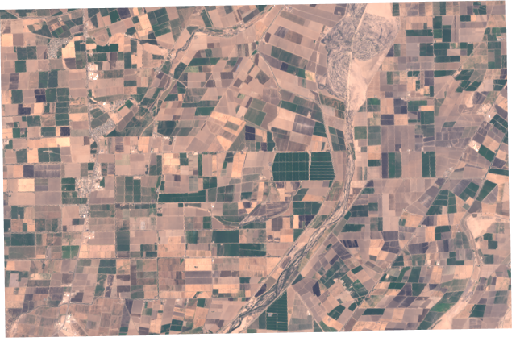

In [6]:
vis_image = ee.Image(landsat_img) \
    .visualize(bands=['B4', 'B3', 'B2'], min=[0, 0, 0], max=[0.3, 0.3, 0.3]) \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .clip(test_geom)
Image(url=vis_image.getThumbURL(), embed=True, format='png')

### Prep the raw Landsat TOA image for use in DisALEXI

The prep function will rename the bands to generic names, compute albedo, ndvi, lai, and extract the fmask image from the BQA band.

In [7]:
input_img = ee.Image(landsat.LandsatTOA(landsat_img).prep())

Show the NDVI band for the validation asset area

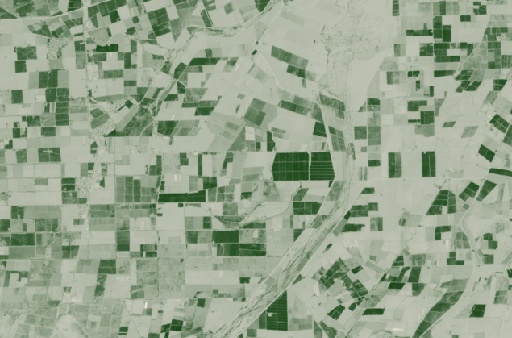

In [8]:
vis_img = input_img.select(['ndvi']).getThumbURL({
    'region': test_region, 'min':-0.1, 'max':0.9, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

Show the NDVI band for the test site area

In [9]:
# Image(url=input_img.select(['ndvi']).getThumbURL({
#         'region': test_region, 'min':-0.1, 'max':0.9, 'palette': ndvi_palette}), 
#       embed=True, format='png')

### Extract input values at the test point

In [10]:
print('LAI:    {:12.8f}'.format(float(utils.image_value(input_img, xy=test_xy, scale=30)['lai'])))
print('NDVI:   {:12.8f}'.format(float(utils.image_value(input_img, xy=test_xy, scale=30)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(utils.image_value(input_img, xy=test_xy, scale=30)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(utils.image_value(input_img, xy=test_xy, scale=30)['lst'])))
print('CFMask: {:12.8f}'.format(float(utils.image_value(input_img, xy=test_xy, scale=30)['cfmask'])))

LAI:      2.73533273
NDVI:     0.73108977
Albedo:   0.24656877
LST:    308.38769255 [K]
CFMask:   0.00000000


### Initialize the DisALEXI object

In [11]:
# Initialize the DisALEXI object using all default values
# NLCD Landcover, NED Elevation, CONUS ALEXI ET
model_obj = disalexi.Image(
    input_img, 
    alexi_et_source='CONUS_V001',
    elevation_source='USGS/SRTMGL1_003',
    landcover_source='GLOBELAND30',
    rs_daily_source='MERRA2',
    rs_hourly_source='MERRA2',
    windspeed_source='CFSV2',
    stabil_iterations=10,
    albedo_iterations=4,
)

### Extract the ancillary values at the test point

In [12]:
# def image_value(image, xy=default_xy, scale=None,
#                 crs=default_crs, crsTransform=default_geo, tile_scale=1):
#     # Default to using Landsat crsTransform unless scale is set

#     if scale is not None:
#         value = image.reduceRegion(
#             reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
#             scale=default_scale, tileScale=tile_scale)
#     else:
#         value = image.reduceRegion(
#             reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
#             crs=crs, crsTransform=crsTransform, tileScale=tile_scale)

In [13]:
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.image_value(model_obj.alexi_et, xy=test_xy, scale=30)['alexi_et'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.image_value(model_obj.elevation, xy=test_xy, scale=30)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.image_value(model_obj.rs1, xy=test_xy, scale=30)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.image_value(model_obj.rs24, xy=test_xy, scale=30)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.image_value(model_obj.windspeed, xy=test_xy, scale=30)['windspeed'])))

ALEXI ET:     6.90102434 [mm]
Elevation:   17.00000000 [m]
Rs Hourly:  929.51891667 [W m-2]
Rs Daily:  8239.91601562 [W m-2]
Wind Speed:   3.97250716 [m/s]


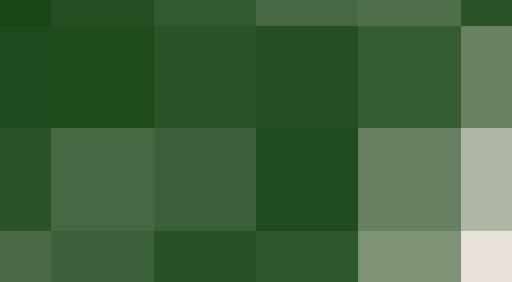

In [14]:
vis_img = model_obj.alexi_et.getThumbURL({
    'region': test_region, 'min':0, 'max':8, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

### Compute Air Temperature

In [15]:
image_transform = ee.Image(landsat_img).select('B2').projection().getInfo()['transform']
print(image_transform)

# Reduce the computation resolution
image_transform = '[' + ','.join(map(str, [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0])) + ']'
# output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
image_transform = [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]
print(image_transform)

[30.0, 0.0, 626985.0, 0.0, -30.0, 3629715.0]
[120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]


In [16]:
t_air_img = ee.Image(model_obj.ta_qm(cellsize=120, ta_values=list(range(250, 351, 1))))
print('Output Ta:\n{}'.format(pprint.pformat(
    utils.image_value(t_air_img, xy=test_xy, scale=120)['ta'])))
# print('Output Ta:\n{}'.format(pprint.pformat(
#     utils.image_value(t_air_img, xy=test_xy, crs=image_crs, crsTransform=image_transform)['ta'])))

Output Ta:
294.0


In [17]:
t_air_url = t_air_img.getThumbURL({
    'region': test_region, 'min':270, 'max':330})
print(t_air_url)

https://earthengine.googleapis.com/api/thumb?thumbid=ca7dcfc56d605d7f54c33ab9bc4e796d&token=08b1e0a8145896c6bcf55805759d1752


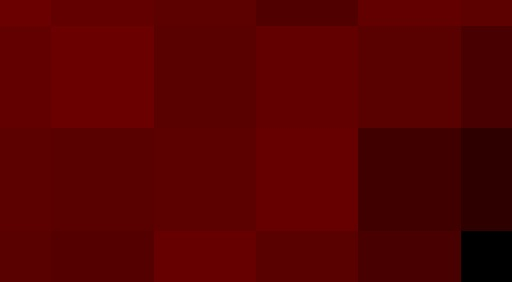

In [18]:
Image(url=t_air_url, embed=True, format='png')

### Aggregate Air Temperature to ALEXI ET cells

In [19]:
# # Test asset ALEXI ET geotransform (from IDL)
# # et_transform = [0.04, 0, -125.042123, 0, -0.04, 49.7764322]
# # CONUS ALEXI ET geotransform
# et_transform = [0.04, 0, -125.0, 0, -0.04, 49.80]

# t_air_coarse_img = model_obj.aggregate(t_air_img) \
#     .reproject(crs='EPSG:4326', crsTransform=et_transform)
# print('Coarse Ta: {}'.format(pprint.pformat(
#     utils.image_value(t_air_coarse_img, xy=test_xy, scale=30)['t_air'])))

In [20]:
# t_air_coarse_url = t_air_coarse_img.getThumbUrl({
#     'region': test_region, 'min':270, 'max':330})
# print(t_air_coarse_url)

In [21]:
# Image(url=t_air_coarse_url, embed=True, format='png')

### Compute ET

In [22]:
# et_img = disalexi.compute_et(t_air_coarse_img) \
#     .reproject(crs=image_crs, crsTransform=image_transform)
# print('ET: {}'.format(pprint.pformat(
#     utils.image_value(et_img, xy=test_xy, scale=30)['et'])))

In [23]:
# et_url = et_img.getThumbURL({
#     'region': test_region, 'min': 1, 'max': 7, 
#     'palette': ','.join(ssebop_et_palette)})
# # print(et_url)

In [24]:
# Image(url=et_url, embed=True, format='png')